In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive

from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client

auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from matplotlib.pyplot import figure


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Loading

In [0]:

link ='https://drive.google.com/open?id=1mUIpxBh7bOx1lXARzU6ybuFi58Q7zolB'

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id})

downloaded.GetContentFile('Data_Train.xlsx')
df_train= pd.read_excel('Data_Train.xlsx')


link ='https://drive.google.com/open?id=1-IOgjWigyxNbFSgV2QK6vIoQjm-JwL2p'

fluff, id = link.split('=')

downloaded = drive.CreateFile({'id':id})

downloaded.GetContentFile('Test_set.xlsx')
df_test= pd.read_excel('Test_set.xlsx')


In [4]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [5]:
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [6]:
print("Number of rows in training dataset",df_train.shape)
print("Number of rows in prediction dataset",df_test.shape)

Number of rows in training dataset (10683, 11)
Number of rows in prediction dataset (2671, 10)


#  Data Cleaning

In [7]:
# Checking and Removing NUll Values

null_columns=df_train.columns[df_train.isnull().any()]
print(df_train[df_train.isnull().any(axis=1)][null_columns].head())
df_train.dropna(inplace=True)


     Route Total_Stops
9039   NaN         NaN


In [8]:
duplicateRowsDF = df_train[df_train.duplicated()]
print("Total Duplicate Rows except first occurrence based on all columns are :")
duplicateRowsDF.shape

Total Duplicate Rows except first occurrence based on all columns are :


(220, 11)

In [0]:
#removing duplicate rows in training dataset

df_train.drop_duplicates(keep='first',inplace=True)

In [10]:
print("Train set:\n",df_train["Additional_Info"].value_counts())
print("\nTest set:\n",df_test["Additional_Info"].value_counts())

Train set:
 No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
1 Short layover                    1
Red-eye flight                     1
Name: Additional_Info, dtype: int64

Test set:
 No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Change airports                    1
Business class                     1
1 Long layover                     1
Name: Additional_Info, dtype: int64


In [0]:
# replacing repeating value in train set
df_train["Additional_Info"] = df_train["Additional_Info"].replace({'No Info': 'No info'})

# Feature Engineering

In [12]:
df_train['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [0]:
# Assigning numerical values to stops

df_train.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df_test.Total_Stops.replace(['1 stop', 'non-stop', '2 stops', '3 stops', '4 stops'], [1, 0, 2, 3, 4], inplace=True)
df_train["Total_Stops"] = df_train["Total_Stops"].astype(int)
df_test["Total_Stops"] = df_test["Total_Stops"].astype(int)

In [14]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1,No info,13302


In [15]:
df_train['Airline'].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [0]:

# Extract day and month of journey from the above column in both train and test dataset

df_train["isWeekend"] = ((pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df_train["Day_of_Week"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df_train["Day_Of_Journey"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.day
df_train["Month_of_Journey"] = pd.to_datetime(df_train["Date_of_Journey"], format = '%d/%m/%Y').dt.month

df_test["isWeekend"] = ((pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.dayofweek) // 5 == 1).astype(int)
df_test["Day_of_Week"] = pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.day_name()
df_test["Day_Of_Journey"] = pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.day
df_test["Month_of_Journey"] = pd.to_datetime(df_test["Date_of_Journey"], format = '%d/%m/%Y').dt.month

In [17]:
df_train.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,0,No info,3897,1,Sunday,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2,No info,7662,0,Wednesday,1,5


In [0]:
# Drop original feature from train and test dataset 

df_train.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)
df_test.drop(labels = 'Date_of_Journey', axis = 1, inplace = True)

In [0]:
#  Arrival time 
df_train['Arrival_Time']=df_train['Arrival_Time'].str.split(' ').str[0]
df_test['Arrival_Time']=df_test['Arrival_Time'].str.split(' ').str[0]

df_train['Arrival_Hour'] = df_train['Arrival_Time'] .str.split(':').str[0]
df_train['Arrival_Minute'] =df_train['Arrival_Time'] .str.split(':').str[1]
df_train['Arrival_Hour']=df_train['Arrival_Hour'].astype(int)
df_train['Arrival_Minute']=df_train['Arrival_Minute'].astype(int)
df_train=df_train.drop(['Arrival_Time'],axis=1)


df_test['Arrival_Hour'] = df_test['Arrival_Time'] .str.split(':').str[0]
df_test['Arrival_Minute'] =df_test['Arrival_Time'] .str.split(':').str[1]
df_test['Arrival_Hour']=df_test['Arrival_Hour'].astype(int)
df_test['Arrival_Minute']=df_test['Arrival_Minute'].astype(int)
df_test=df_test.drop(['Arrival_Time'],axis=1)

In [0]:
#  Departure Time
df_train['Departure_Hour'] = df_train['Dep_Time'] .str.split(':').str[0]
df_train['Departure_Minute'] =df_train['Dep_Time'] .str.split(':').str[1]

df_test['Departure_Hour'] = df_test['Dep_Time'] .str.split(':').str[0]
df_test['Departure_Minute'] =df_test['Dep_Time'] .str.split(':').str[1]


df_train['Departure_Hour']=df_train['Departure_Hour'].astype(int)
df_train['Departure_Minute']=df_train['Departure_Minute'].astype(int)
df_train=df_train.drop(['Dep_Time'],axis=1)

df_test['Departure_Hour']=df_test['Departure_Hour'].astype(int)
df_test['Departure_Minute']=df_test['Departure_Minute'].astype(int)
df_test=df_test.drop(['Dep_Time'],axis=1)

In [21]:
df_train.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,0,No info,3897,1,Sunday,24,3,1,10,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662,0,Wednesday,1,5,13,15,5,50


In [0]:
# Duration column

df_train['Duration_hour']=df_train.Duration.str.split(' ').str[0]
df_train['Duration_min']=df_train.Duration.str.split(' ').str[1]

df_test['Duration_hour']=df_test.Duration.str.split(' ').str[0]
df_test['Duration_min']=df_test.Duration.str.split(' ').str[1]

df_train['Dur_hour']=df_train.Duration_hour.str.split('h').str[0]
df_train['Dur_min']=df_train.Duration_min.str.split('m').str[0]

df_test['Dur_hour']=df_test.Duration_hour.str.split('h').str[0]
df_test['Dur_min']=df_test.Duration_min.str.split('m').str[0]

df_train['Dur_min'].fillna("0",inplace=True)
df_train['Dur_hour'].fillna("0",inplace=True)

df_test['Dur_min'].fillna("0",inplace=True)
df_test['Dur_hour'].fillna("0",inplace=True)

df_train['Dur_hour']=df_train['Dur_hour'].replace('5m','0')
df_test['Dur_hour']=df_test['Dur_hour'].replace('5m','0')

df_train['Dur_hour']=df_train['Dur_hour'].astype(int)
df_train['Dur_min']=df_train['Dur_min'].astype(int)

df_test['Dur_hour']=df_test['Dur_hour'].astype(int)
df_test['Dur_min']=df_test['Dur_min'].astype(int)

df_train['Total_Duration']=df_train['Dur_hour']*60+df_train['Dur_min']

df_test['Total_Duration']=df_test['Dur_hour']*60+df_test['Dur_min']



In [23]:
df_train.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Duration_hour,Duration_min,Dur_hour,Dur_min,Total_Duration
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,0,No info,3897,1,Sunday,24,3,1,10,22,20,2h,50m,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662,0,Wednesday,1,5,13,15,5,50,7h,25m,7,25,445


In [0]:
#  Route

df_train['Route_1']=df_train['Route'].str.split('→ ').str[0]
df_train['Route_2']=df_train['Route'].str.split('→ ').str[1]
df_train['Route_3']=df_train['Route'].str.split('→ ').str[2]
df_train['Route_4']=df_train['Route'].str.split('→ ').str[3]
df_train['Route_5']=df_train['Route'].str.split('→ ').str[4]

df_test['Route_1']=df_test['Route'].str.split('→ ').str[0]
df_test['Route_2']=df_test['Route'].str.split('→ ').str[1]
df_test['Route_3']=df_test['Route'].str.split('→ ').str[2]
df_test['Route_4']=df_test['Route'].str.split('→ ').str[3]
df_test['Route_5']=df_test['Route'].str.split('→ ').str[4]

df_train['Route_1'].fillna("None",inplace=True)
df_train['Route_2'].fillna("None",inplace=True)
df_train['Route_3'].fillna("None",inplace=True)
df_train['Route_4'].fillna("None",inplace=True)
df_train['Route_5'].fillna("None",inplace=True)

df_test['Route_1'].fillna("None",inplace=True)
df_test['Route_2'].fillna("None",inplace=True)
df_test['Route_3'].fillna("None",inplace=True)
df_test['Route_4'].fillna("None",inplace=True)
df_test['Route_5'].fillna("None",inplace=True)


In [25]:
df_train.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Duration_hour,Duration_min,Dur_hour,Dur_min,Total_Duration,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,0,No info,3897,1,Sunday,24,3,1,10,22,20,2h,50m,2,50,170,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2,No info,7662,0,Wednesday,1,5,13,15,5,50,7h,25m,7,25,445,CCU,IXR,BBI,BLR,None


In [0]:
train_df_2=df_train.copy().drop(columns=['Duration','Duration_hour','Duration_min','Dur_hour','Dur_min','Route'])

In [27]:
train_df_2

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Total_Duration,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,No info,3897,1,Sunday,24,3,1,10,22,20,170,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,2,No info,7662,0,Wednesday,1,5,13,15,5,50,445,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,2,No info,13882,1,Sunday,9,6,4,25,9,25,1140,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,1,No info,6218,1,Sunday,12,5,23,30,18,5,325,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,1,No info,13302,0,Friday,1,3,21,35,16,50,285,BLR,NAG,DEL,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,0,No info,4107,0,Tuesday,9,4,22,25,19,55,150,CCU,BLR,None,None,None
10679,Air India,Kolkata,Banglore,0,No info,4145,1,Saturday,27,4,23,20,20,45,155,CCU,BLR,None,None,None
10680,Jet Airways,Banglore,Delhi,0,No info,7229,1,Saturday,27,4,11,20,8,20,180,BLR,DEL,None,None,None
10681,Vistara,Banglore,New Delhi,0,No info,12648,0,Friday,1,3,14,10,11,30,160,BLR,DEL,None,None,None


In [0]:
test_df_2=df_test.copy().drop(columns=['Duration','Duration_hour','Duration_min','Dur_hour','Dur_min','Route'])

In [29]:
test_df_2.head(2)

,Airline,Source,Destination,Total_Stops,Additional_Info,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Total_Duration,Route_1,Route_2,Route_3,Route_4,Route_5
0,Jet Airways,Delhi,Cochin,1,No info,0,Thursday,6,6,4,25,17,30,655,DEL,BOM,COK,None,None
1,IndiGo,Kolkata,Banglore,1,No info,1,Sunday,12,5,10,20,6,20,240,CCU,MAA,BLR,None,None


In [30]:
train_df_2.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Price', 'isWeekend', 'Day_of_Week', 'Day_Of_Journey',
       'Month_of_Journey', 'Arrival_Hour', 'Arrival_Minute', 'Departure_Hour',
       'Departure_Minute', 'Total_Duration', 'Route_1', 'Route_2', 'Route_3',
       'Route_4', 'Route_5'],
      dtype='object')

In [31]:
test_df_2.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'isWeekend', 'Day_of_Week', 'Day_Of_Journey', 'Month_of_Journey',
       'Arrival_Hour', 'Arrival_Minute', 'Departure_Hour', 'Departure_Minute',
       'Total_Duration', 'Route_1', 'Route_2', 'Route_3', 'Route_4',
       'Route_5'],
      dtype='object')

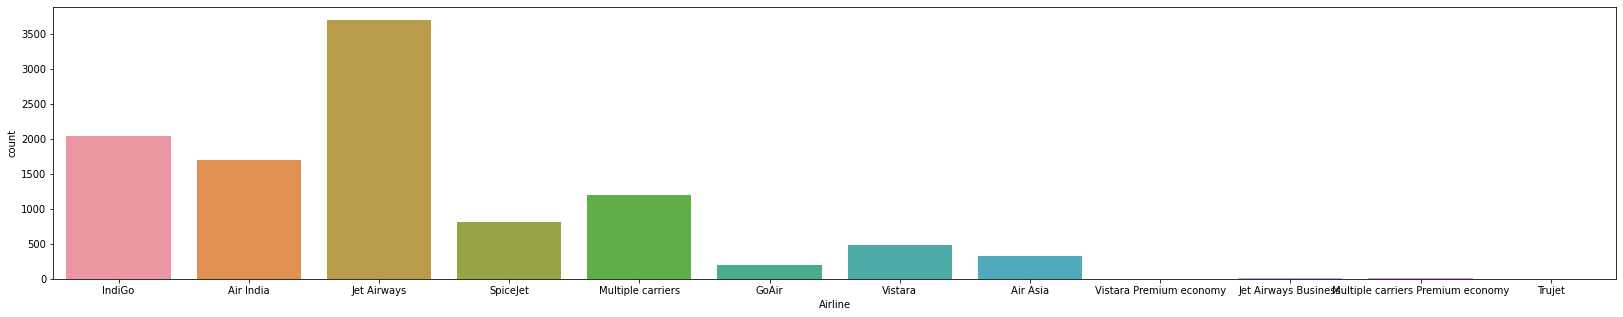

In [32]:

plt.figure(figsize=(28,5))
sns.countplot(x = 'Airline',data =df_train)

In [0]:
train_df_2["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)
test_df_2["Airline"].replace(to_replace={'Multiple carriers Premium economy':'Other', 
                                                        'Jet Airways Business':'Other',
                                                        'Vistara Premium economy':'Other',
                                                        'Trujet':'Other'
                                                   },    
                                        inplace=True)

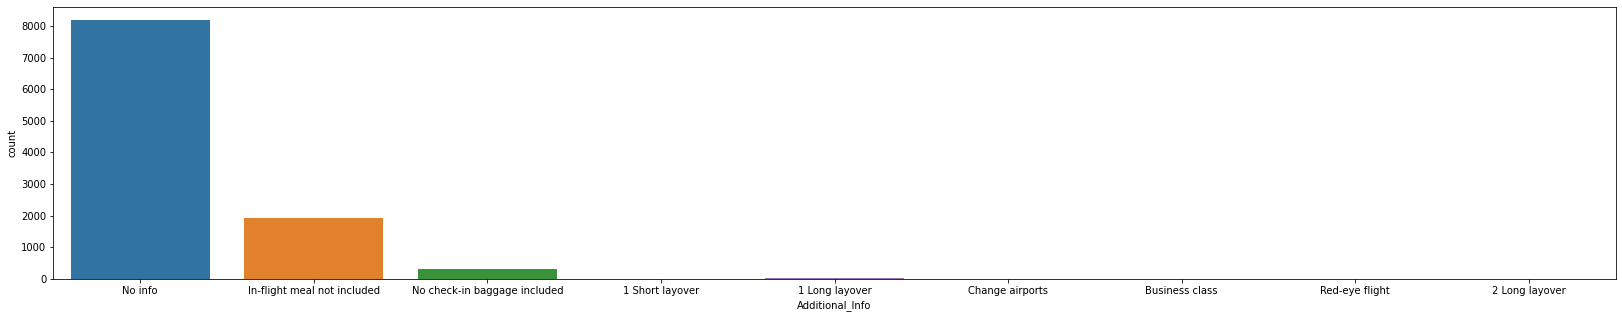

In [34]:
plt.figure(figsize=(28,5))
sns.countplot(x = 'Additional_Info',data =df_train)

In [0]:
train_df_2["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other',
                                                        '1 Long layover':'Other',   
                                                   },    
                                        inplace=True)
test_df_2["Additional_Info"].replace(to_replace={'Change airports':'Other', 
                                                        'Business class':'Other',
                                                        '1 Short layover':'Other',
                                                        'Red-eye flight':'Other',
                                                        '2 Long layover':'Other', 
                                                         '1 Long layover':'Other',  
                                                   },    
                                        inplace=True)

In [36]:
train_df_2["Additional_Info"].value_counts()

No info                         8185
In-flight meal not included     1926
No check-in baggage included     318
Other                             33
Name: Additional_Info, dtype: int64

In [37]:
test_df_2["Additional_Info"].value_counts()

No info                         2148
In-flight meal not included      444
No check-in baggage included      76
Other                              3
Name: Additional_Info, dtype: int64

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
train_df_2["Airline"]=encoder.fit_transform(train_df_2['Airline'])
train_df_2["Source"]=encoder.fit_transform(train_df_2['Source'])
train_df_2["Destination"]=encoder.fit_transform(train_df_2['Destination'])
train_df_2["Additional_Info"]=encoder.fit_transform(train_df_2['Additional_Info'])
train_df_2["Route_1"]=encoder.fit_transform(train_df_2['Route_1'])
train_df_2["Route_2"]=encoder.fit_transform(train_df_2['Route_2'])
train_df_2["Route_3"]=encoder.fit_transform(train_df_2['Route_3'])
train_df_2["Route_4"]=encoder.fit_transform(train_df_2['Route_4'])
train_df_2["Route_5"]=encoder.fit_transform(train_df_2['Route_5'])
train_df_2["Day_of_Week"]=encoder.fit_transform(train_df_2['Day_of_Week'])

In [39]:
train_df_2.head(2)

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Total_Duration,Route_1,Route_2,Route_3,Route_4,Route_5
0,3,0,5,0,2,3897,1,3,24,3,1,10,22,20,170,0,13,24,12,4
1,1,3,0,2,2,7662,0,6,1,5,13,15,5,50,445,2,25,1,3,4


In [0]:
test_df_2["Airline"]=encoder.fit_transform(test_df_2['Airline'])
test_df_2["Source"]=encoder.fit_transform(test_df_2['Source'])
test_df_2["Destination"]=encoder.fit_transform(test_df_2['Destination'])
test_df_2["Additional_Info"]=encoder.fit_transform(test_df_2['Additional_Info'])
test_df_2["Route_1"]=encoder.fit_transform(test_df_2['Route_1'])
test_df_2["Route_2"]=encoder.fit_transform(test_df_2['Route_2'])
test_df_2["Route_3"]=encoder.fit_transform(test_df_2['Route_3'])
test_df_2["Route_4"]=encoder.fit_transform(test_df_2['Route_4'])
test_df_2["Route_5"]=encoder.fit_transform(test_df_2['Route_5'])
test_df_2["Day_of_Week"]=encoder.fit_transform(test_df_2['Day_of_Week'])

In [41]:
test_df_2.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Total_Duration,Route_1,Route_2,Route_3,Route_4,Route_5
0,4,2,1,1,2,0,4,6,6,4,25,17,30,655,3,7,5,8,3
1,3,3,0,1,2,1,3,12,5,10,20,6,20,240,2,29,3,8,3
2,4,2,1,1,0,0,5,21,5,19,0,19,15,1425,3,7,5,8,3
3,5,2,1,1,2,0,5,21,5,21,0,8,0,780,3,7,5,8,3
4,0,0,2,0,2,0,1,24,6,2,45,23,55,170,0,13,21,8,3


In [42]:
train_df_2.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Price', 'isWeekend', 'Day_of_Week', 'Day_Of_Journey',
       'Month_of_Journey', 'Arrival_Hour', 'Arrival_Minute', 'Departure_Hour',
       'Departure_Minute', 'Total_Duration', 'Route_1', 'Route_2', 'Route_3',
       'Route_4', 'Route_5'],
      dtype='object')

In [43]:
test_df_2.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'isWeekend', 'Day_of_Week', 'Day_Of_Journey', 'Month_of_Journey',
       'Arrival_Hour', 'Arrival_Minute', 'Departure_Hour', 'Departure_Minute',
       'Total_Duration', 'Route_1', 'Route_2', 'Route_3', 'Route_4',
       'Route_5'],
      dtype='object')

#EDA

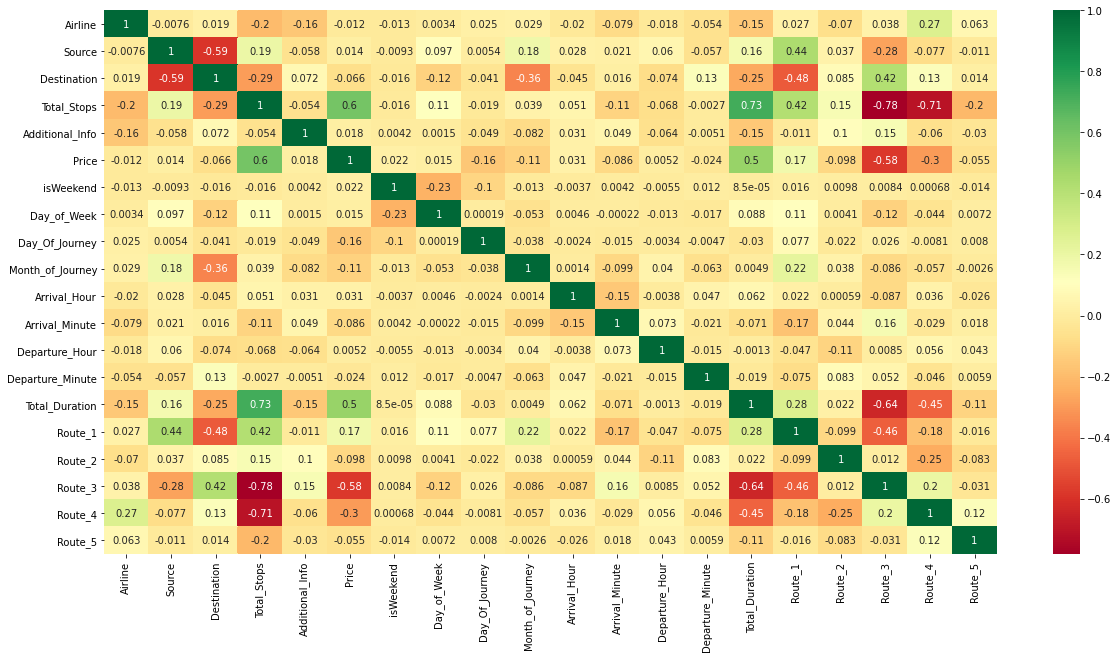

In [44]:
# plotting correlation plot 

corrmat =train_df_2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,10))
g=sns.heatmap(train_df_2[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Text(0.5, 1.0, 'Total stops')

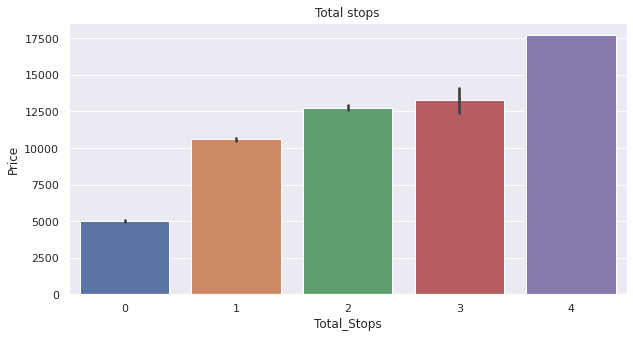

In [45]:
# plotting price Vs Total stops

sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="Total_Stops", y="Price", data=train_df_2)
plt.title('Total stops')

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]), <a list of 9 Text major ticklabel objects>)

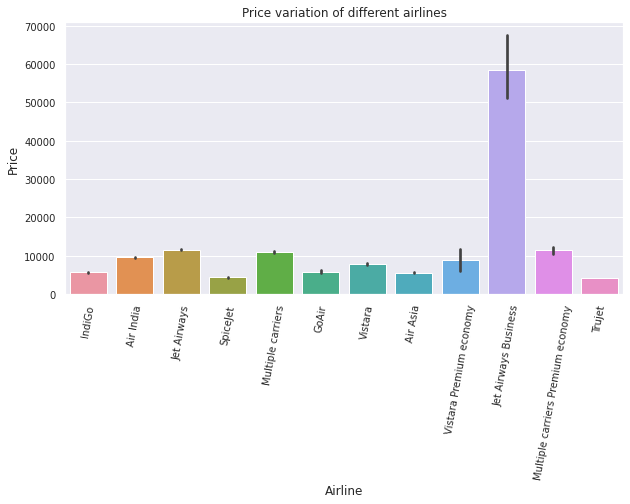

In [46]:
# plotting price Vs Price variation of different airlines

sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="Airline", y="Price", data=df_train)
plt.title('Price variation of different airlines')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)

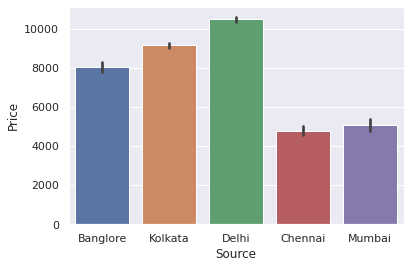

In [47]:
#Plotting price Vs Source of the flight
sns.barplot(y = 'Price',x = 'Source',data =df_train)

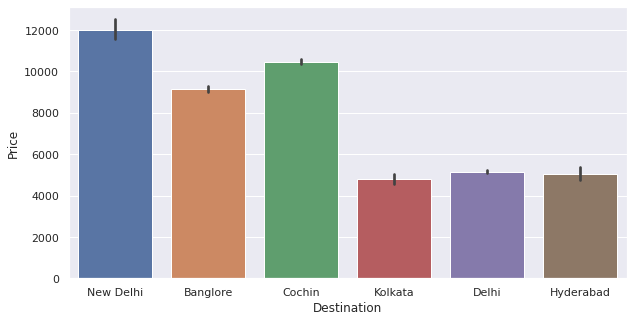

In [48]:
#Plotting price Vs Destination of the flight

figure(figsize=(10,5)) 
sns.barplot(y= 'Price',x = 'Destination',data =df_train)

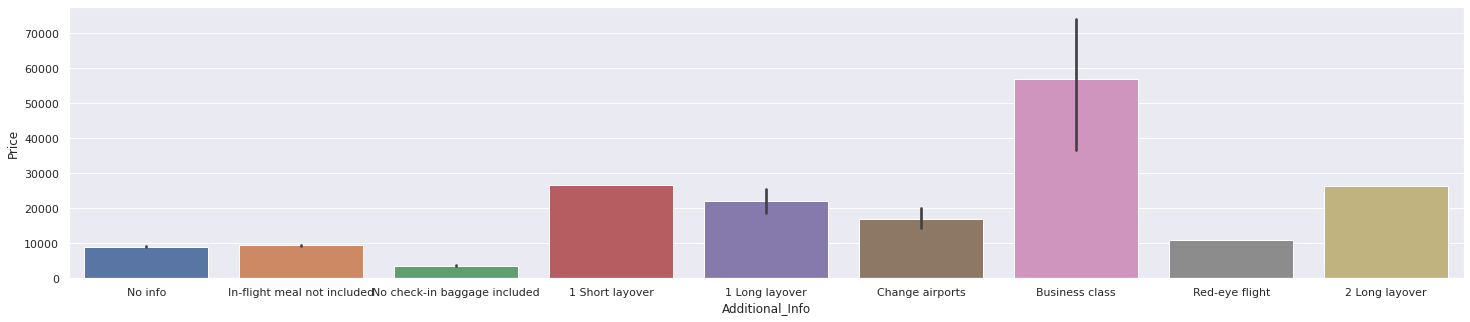

In [49]:
#Plotting price Vs given additional info

figure(figsize=(25,5)) 
sns.barplot(y = 'Price',x= 'Additional_Info',data =df_train)

#Model Selection and Predictions

In [0]:
price=train_df_2['Price']
features=train_df_2.copy().drop(columns=['Price'])


In [51]:
price.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

In [52]:
features.head(2)

,Airline,Source,Destination,Total_Stops,Additional_Info,isWeekend,Day_of_Week,Day_Of_Journey,Month_of_Journey,Arrival_Hour,Arrival_Minute,Departure_Hour,Departure_Minute,Total_Duration,Route_1,Route_2,Route_3,Route_4,Route_5
0,3,0,5,0,2,1,3,24,3,1,10,22,20,170,0,13,24,12,4
1,1,3,0,2,2,0,6,1,5,13,15,5,50,445,2,25,1,3,4


In [0]:
# splitting the trainin dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(features,price,test_size=0.25,random_state=0)

In [54]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(7846, 19)
(7846,)
(2616, 19)
(2616,)


In [0]:
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error

#function for plotting report

def print_accuracy_report(y_test, y_pred,X_test, model):
  print('R Squared(Accuracy)', metrics.r2_score(y_test, y_pred))   
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print('Root Mean Squared Log Error',np.sqrt(mean_squared_log_error( y_test, y_pred )))

In [0]:
#function for plotting Important features from the Models

def plotFeatureImportances(model):
    feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print(feature_importances)
    feature = features.columns.tolist()
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [0]:
#using random forest regressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
random_forest_regressor=RandomForestRegressor()
n_estimators = [100,200,300,400,500]
max_depth = [5,10,15,20,30,40]
min_samples_split=[5,10,15,20,30,40]
min_samples_leaf=[5,10,15,20,30,40]

In [0]:
hyperparameter_rfr = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
    }

In [0]:
rfr_cv =  RandomizedSearchCV(random_forest_regressor,hyperparameter_rfr,cv=5,n_jobs = -1,verbose = 5,scoring ='neg_mean_squared_log_error',n_iter=10)

In [60]:
rfr_cv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [61]:
rfr_cv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [62]:
y_pred_rfr = rfr_cv.best_estimator_.predict(x_test)
print(print_accuracy_report(y_test, y_pred_rfr, x_test, rfr_cv.best_estimator_))

R Squared(Accuracy) 0.8750006126089562
Mean Absolute Error: 787.3125755050324
Mean Squared Error: 2650801.281032645
Root Mean Squared Error: 1628.1281525213687
Root Mean Squared Log Error 0.13839710330220303
None


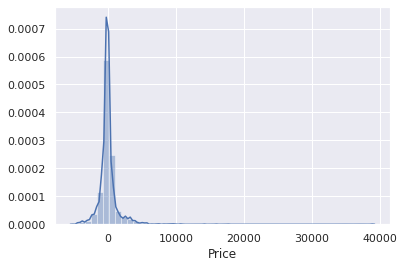

In [63]:
sns.distplot(y_test-y_pred_rfr)

                  importance
Total_Duration      0.479632
Airline             0.133346
Day_Of_Journey      0.082233
Additional_Info     0.061503
Total_Stops         0.042280
Month_of_Journey    0.042053
Route_2             0.027024
Day_of_Week         0.023414
Destination         0.022555
Route_3             0.017776
Departure_Hour      0.012587
Arrival_Hour        0.011592
Departure_Minute    0.011411
Arrival_Minute      0.010434
Route_4             0.008437
Route_1             0.007127
Source              0.004083
isWeekend           0.002513
Route_5             0.000001


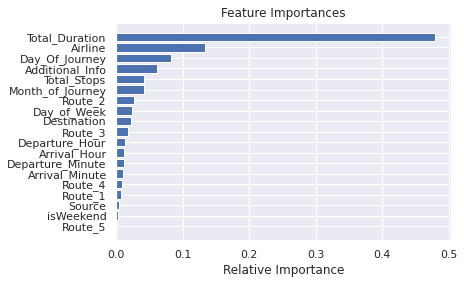

In [64]:
plotFeatureImportances(rfr_cv.best_estimator_)

In [0]:
#using xgboost

import xgboost
xgb_regressor=xgboost.XGBRegressor()

In [0]:
booster=['gbtree']
base_score=[0.25,0.5,0.75,1]
n_estimators = [100,200,300,400,500]
max_depth = [5,10,15,20,30,40]
learning_rate=[0.01,0.05,0.1,0.15,0.20]


In [0]:
hyperparameter_xgb = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'booster':booster,
    'base_score':base_score,
    }

In [0]:
xgb_cv = RandomizedSearchCV(estimator=xgb_regressor,
            param_distributions=hyperparameter_xgb,
            cv=5,
            n_iter=10,
            scoring ='neg_mean_squared_log_error',
            n_jobs = -1,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [69]:
xgb_cv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.7min finished


[05:23:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          verbosity=1),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1

In [70]:
xgb_cv.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [71]:
y_pred_xgb = xgb_cv.best_estimator_.predict(x_test)
print(print_accuracy_report(y_test, y_pred_xgb, x_test, rfr_cv.best_estimator_))

R Squared(Accuracy) 0.902891200240994
Mean Absolute Error: 630.608370393059
Mean Squared Error: 2059339.1389625291
Root Mean Squared Error: 1435.0397691222809
Root Mean Squared Log Error 0.12325461953636184
None


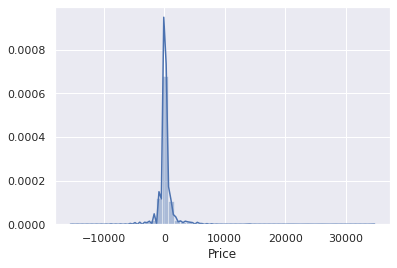

In [72]:
sns.distplot(y_test-y_pred_xgb)

                  importance
Destination         0.291039
Total_Stops         0.253738
Total_Duration      0.167914
Additional_Info     0.070783
Route_3             0.065750
Airline             0.050093
Month_of_Journey    0.019899
Route_2             0.019759
Day_Of_Journey      0.017371
Source              0.008497
Day_of_Week         0.006960
Route_1             0.006565
Route_4             0.005264
Departure_Minute    0.004678
Departure_Hour      0.004343
Arrival_Hour        0.003064
Arrival_Minute      0.002599
isWeekend           0.001684
Route_5             0.000000


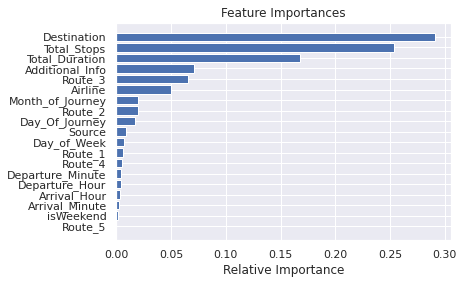

In [73]:
plotFeatureImportances(xgb_cv.best_estimator_)